In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from utils import calculate_random_walk_matrix
from model_sigformer import SIGFormer

import scienceplots

plt.style.use(['science','nature','no-latex'])
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

def set_global_seed(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# set_global_seed(1)

In [2]:
def get_data(r_m):
    A = np.load('data/pems_flow/adj_mat.npy')
    X = np.load('data/pems_flow/node_values.npy').transpose()

    A = np.array(A, dtype=np.float32)
    X = np.array(X, dtype=np.float32)
    print(A.shape, X.shape)
    
    max_X = np.max(X)

    split_line1 = int(X.shape[1] * 0.6)
    split_line2 = int(X.shape[1] * 0.8)

    training_set = X[:, :split_line1].transpose()
    val_set = X[:, split_line1:split_line2].transpose()
    test_set = X[:, split_line2:].transpose()
    print('training_set',training_set.shape)
    print('validation_set',val_set.shape)
    print('test_set',test_set.shape)

    UNKNOWN_SET = set(selected_id)
    unknow_set = UNKNOWN_SET
 
    full_set = set(range(0,X.shape[0]))        
    know_set = full_set - unknow_set
    # know_set = full_set
#     print("know_set", know_set)
    training_set_s = training_set[:, list(know_set)]   
    A_s = A[:, list(know_set)][list(know_set), :]

    return A,X,training_set,test_set,unknow_set,full_set,know_set,training_set_s,A_s,max_X

In [3]:
def evaluate_experiment_pattern(model, new_ids, given_ids, test_set, A, device, r_m, t, E_maxvalue):
    # Combine new and given sensor IDs.
    exp_id_set = set(np.concatenate((new_ids, given_ids)))
    exp_ids = sorted(list(exp_id_set))
    
    # Extract experiment data.
    exp_data = test_set[:, exp_ids]   # shape: (time, num_exp_sensors)
    A_exp = A[:, exp_ids][exp_ids, :]
    
    unknown_set = set(new_ids)
    time_dim = t

    # Create observation mask.
    obs_mask = np.ones(exp_data.shape)
    test_inputs = (exp_data * obs_mask).astype('float32')
    
    # Create missing mask: set columns corresponding to unknown sensors to 0.
    missing_mask = np.ones(exp_data.shape)
    new_idx = [exp_ids.index(s) for s in exp_ids if s in unknown_set]
    for j in new_idx:
        missing_mask[:, j] = 0

    num_windows = exp_data.shape[0] // time_dim
    output = np.zeros((num_windows * time_dim, exp_data.shape[1]))
    
    for i in range(0, num_windows * time_dim, time_dim):
        window = test_inputs[i:i+time_dim, :]
        window_missing = missing_mask[i:i+time_dim, :]
        T_inputs = window * window_missing
        T_inputs = T_inputs / E_maxvalue
        T_inputs = np.expand_dims(T_inputs, axis=0)  # add batch dimension
        T_inputs = torch.from_numpy(T_inputs.astype('float32')).to(device)
        
        # Compute graph matrices for A_exp.
        A_q = torch.from_numpy((calculate_random_walk_matrix(A_exp).T).astype('float32')).to(device)
        A_h = torch.from_numpy((calculate_random_walk_matrix(A_exp.T).T).astype('float32')).to(device)
        
        model.eval()
        with torch.no_grad():
            imputation = model(T_inputs, A_q, A_h)
            if device.type == "cuda":
                imputation = imputation.cuda().data.cpu().numpy()
            else:
                imputation = imputation.data.numpy()

            imputation[:,window_missing == 1] = window[window_missing == 1]
            output[i:i+time_dim, :] = imputation[0, :, :]
            
    
    output = output * E_maxvalue
    truth = test_inputs[:num_windows*time_dim, :] * E_maxvalue

    # Replace reconstructed values with ground truth where data was observed.
    # output[window_missing == 1] = truth[window_missing == 1]

    test_mask = 1 - missing_mask[:num_windows*time_dim, :]
    MAE = np.sum(np.abs(output - truth)) / np.sum(test_mask)
    RMSE = np.sqrt(np.sum((output - truth)**2) / np.sum(test_mask))
    MAPE = np.sum(np.abs(output - truth)/(truth + 1e-5)) / np.sum(test_mask)
    
    return MAE, RMSE, MAPE, output, truth, missing_mask, exp_ids, new_ids, given_ids

In [4]:
def exp_pattern(STmodel, new_id, given_id, test_set, A, device, r_m, t):

    exp_id_set = set(np.concatenate((new_id, given_id)))
    exp_id_list = list(exp_id_set)
    test_data = test_set[:, list(exp_id_set)]
    A_exp = A[:, list(exp_id_set)][list(exp_id_set), :]
    exp_set = test_data

    unknow_set = set(new_id)
    time_dim = t

    test_omask = np.ones(exp_set.shape)
    test_inputs = (exp_set * test_omask).astype('float32')
    test_inputs_s = test_inputs

    missing_index = np.ones(np.shape(test_set))
    missing_index[:, list(unknow_set)] = 0
    missing_index_s = missing_index[:, list(exp_id_set)]

    o = np.zeros([exp_set.shape[0]//time_dim*time_dim, int(test_inputs_s.shape[1])]) 
    for i in range(0, exp_set.shape[0]//time_dim*time_dim, time_dim):
        inputs = test_inputs_s[i:i+time_dim, :]
        missing_inputs = missing_index_s[i:i+time_dim, :]
        T_inputs = inputs * missing_inputs
        T_inputs = T_inputs / E_maxvalue
        T_inputs = np.expand_dims(T_inputs, axis=0)
        T_inputs = torch.from_numpy(T_inputs.astype('float32')).to(device)

        A_q = torch.from_numpy((calculate_random_walk_matrix(A_exp).T).astype('float32')).to(device)
        A_h = torch.from_numpy((calculate_random_walk_matrix(A_exp.T).T).astype('float32')).to(device)
        
        STmodel.eval()
        with torch.no_grad():
            imputation = STmodel(T_inputs, A_q, A_h)
            if device.type == "cuda":
                imputation = imputation.cuda().data.cpu().numpy()
            else:
                imputation = imputation.data.numpy()
            o[i:i+time_dim, :] = imputation

    o = o*E_maxvalue
    truth = test_inputs_s[0:exp_set.shape[0]//time_dim*time_dim]
    o[missing_index_s[0:exp_set.shape[0]//time_dim*time_dim] == 1] = truth[missing_index_s[0:exp_set.shape[0]//time_dim*time_dim] == 1]
    test_mask =  1 - missing_index_s[0:exp_set.shape[0]//time_dim*time_dim]


    MAE = np.sum(np.abs(o - truth))/np.sum( test_mask)
    RMSE = np.sqrt(np.sum((o - truth)*(o - truth))/np.sum( test_mask) )
    MAPE = np.sum(np.abs(o - truth)/(truth + 1e-5))/np.sum( test_mask)
    pred, truth = o, truth
    return MAE, RMSE, MAPE, pred, truth, missing_index_s, exp_id_list, new_id, given_id

In [5]:
dataset= "pems_flow"
selected_id = np.loadtxt('data/pems_flow/selected_id.txt', dtype=np.int64)
selected_id = np.unique(selected_id)
r_m = 0.25
t = 24
E_maxvalue = 220
A,X,training_set,test_set,unknow_set,full_set,know_set,training_set_s,A_s,max_X = get_data(r_m)

(205, 205) (205, 17568)
training_set (10540, 205)
validation_set (3514, 205)
test_set (3514, 205)


In [6]:
new_id = np.random.choice(list(unknow_set), 30, replace=False)
given_id = np.random.choice(list(full_set-set(list(new_id))), 90, replace=False)

In [7]:
PATTERN = ['cs', 's', 't', 'b', 'r']
PATTERN_ = ['Completely Spatial Missing', 'Spatial Missing', 'Temporal Missing', 'Block Missing', 'Random Missing']
pred_list = []
truth_list = []
for p in PATTERN:
    # device = torch.device("cuda:0")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    STmodel = SIGFormer(h=24, z=128, k=1, L=1, heads=4, heads_temp=1, ff_hidden_dim=128)
    model_name = 'checkpoints/SIGFormer_pems_flow/best_model_p='+p+'_r_m='+str(r_m)+'.pth'
    STmodel.load_state_dict(torch.load(model_name, map_location=torch.device('cpu'), weights_only=True))
    STmodel.to(device)
    MAE, RMSE, MAPE, pred, truth, missing_index_s, exp_id_list, new_id, given_id = exp_pattern(STmodel, new_id, given_id, test_set, A, device, r_m, t)
    pred_list.append(pred)
    truth_list.append(truth)
    print(p, MAE)

cs 9.178178505344997
s 29.08987750008141
t 25.234754736163573
b 26.7909962179539
r 24.1928614750513


C:\Users\keshuw\AppData\Local\Temp\ipykernel_63124\3081655225.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')
C:\Users\keshuw\AppData\Local\Temp\ipykernel_63124\3081655225.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar_ax.set_yticklabels(ticklabs, fontsize=13)


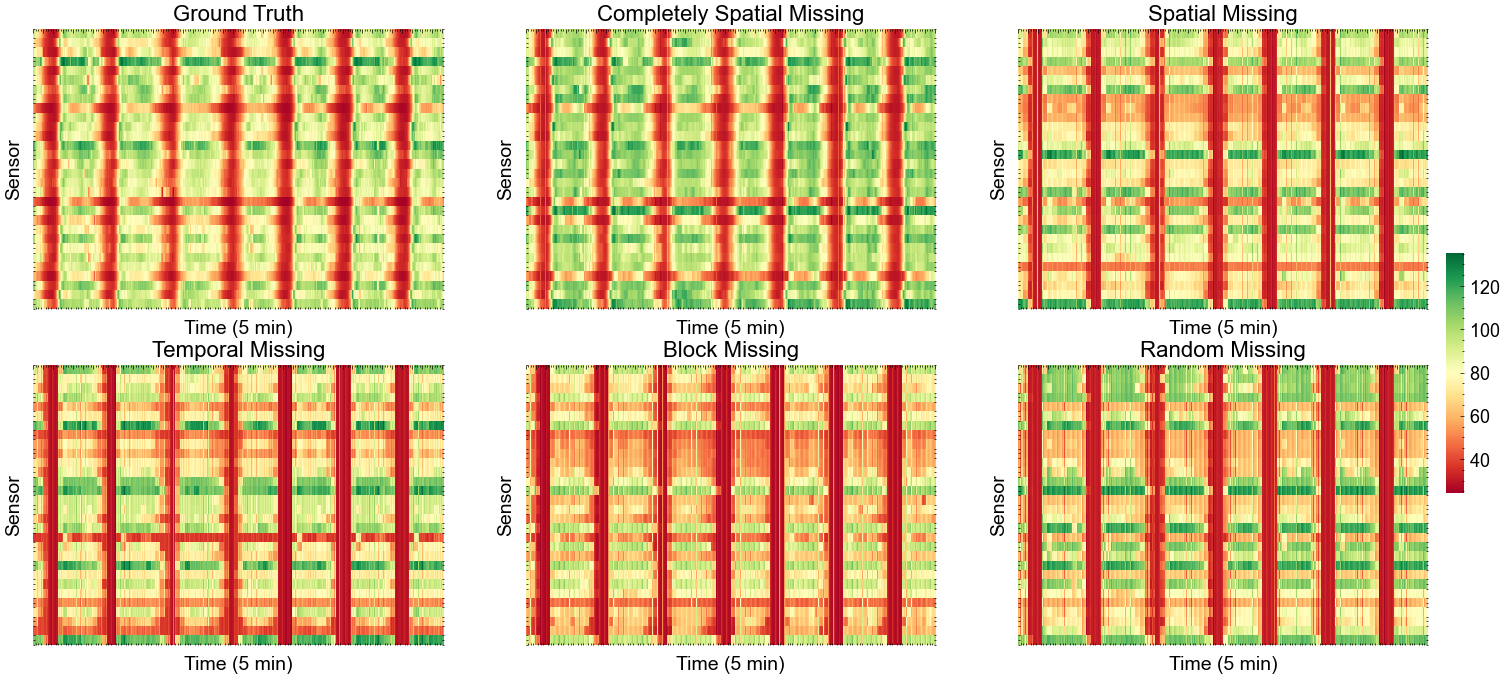

In [8]:
new_id_ = []
for i in range(len(exp_id_list)):
    if exp_id_list[i] in new_id:
        new_id_.append(i)
        
fig = plt.figure(figsize=(18,8))
    
cbar_ax = fig.add_axes([.91, .3, .01, .3])
cmap = plt.cm.get_cmap('RdYlGn')
ticklabs = cbar_ax.get_yticklabels()
cbar_ax.set_yticklabels(ticklabs, fontsize=13)

ax = plt.subplot(2,3,1)

for i in range(len(PATTERN_)+1):
    ax = plt.subplot(2,3,i+1)
    if i == 0:
        sns.heatmap(np.array(truth_list)[0,:288*7,new_id_], cmap=cmap, cbar_ax = cbar_ax)
        plt.title('Ground Truth', fontsize=16)
    else:
        sns.heatmap(np.array(pred_list)[i-1,:288*7,new_id_], cmap=cmap, cbar_ax = cbar_ax)
        plt.title(PATTERN_[i-1], fontsize=16)
    ax.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    plt.xlabel('Time (5 min)', fontsize=14)
    plt.ylabel('Sensor', fontsize=14)
plt.show()